### scikit-mobility tutorials

# 3 - Trajectory models

Generative models of individual trajectories.

- [Density EPR](#Density-EPR)

In [1]:
import skmob

%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

## Exploration and Preferential Return EPR

### Density EPR

In [2]:
from skmob.models.epr import DensityEPR
from skmob.models.epr import load_spatial_tessellation, compute_od_matrix

In [3]:
start_time = pd.to_datetime('2019/01/01 08:00:00')
end_time = pd.to_datetime('2019/01/14 08:00:00')
depr = DensityEPR()

In [4]:
spatial_tessellation = load_spatial_tessellation('data/location2info_trentino')

6259it [00:00, 184353.68it/s]


In [5]:
print(len(spatial_tessellation))
list(spatial_tessellation.items())[:5]

6256


[(0, {'lat': 46.1406015715, 'lng': 10.715532135, 'relevance': 3140}),
 (1, {'lat': 46.1404065626, 'lng': 10.7284735947, 'relevance': 10181}),
 (2, {'lat': 46.1417408692, 'lng': 10.6378806147, 'relevance': 539}),
 (3, {'lat': 46.1415546479, 'lng': 10.6508228586, 'relevance': 106}),
 (4, {'lat': 46.1421089176, 'lng': 10.6119957464, 'relevance': 1400})]

In [6]:
od_matrix = compute_od_matrix(spatial_tessellation, use_relevance=True)

100%|██████████| 6256/6256 [02:08<00:00, 48.56it/s]


In [7]:
tdf = depr.generate(start_time, end_time, spatial_tessellation, 
                    n_agents=100, od_matrix=od_matrix, verbose=True)

100%|██████████| 100/100 [00:17<00:00,  6.40it/s]


In [8]:
tdf.parameters

{'model': {'class': <function skmob.models.epr.DensityEPR.__init__(self, name='Density EPR model', rho=0.6, gamma=0.21, beta=0.8, tau=17, min_wait_time_minutes=10)>,
  'generate': {'start_date': Timestamp('2019-01-01 08:00:00'),
   'end_date': Timestamp('2019-01-14 08:00:00'),
   'n_agents': 100,
   'starting_location': None,
   'random_state': None,
   'verbose': True}}}

In [9]:
tdf.head()

,uid,datetime,lat,lng
0,1,2019-01-01 08:00:00.000000,45.906822,11.224039
1,1,2019-01-01 08:15:39.907045,45.906822,11.224039
2,1,2019-01-01 08:25:49.745623,45.961531,11.187510
3,1,2019-01-01 08:55:33.694431,45.961531,11.187510
4,1,2019-01-01 09:06:33.732152,45.961531,11.187510


In [10]:
from skmob.preprocessing import detection, clustering

In [11]:
stops_tdf = detection.stops(tdf, spatial_radius=0.2)
cluster_tdf = clustering.cluster(stops_tdf)

In [12]:
agent_id = 2

tdf[tdf.uid == agent_id].head()

,uid,datetime,lat,lng
359,2,2019-01-01 08:00:00.000000,45.838917,11.002414
360,2,2019-01-01 08:14:16.709022,45.838917,11.002414
361,2,2019-01-01 08:30:40.706292,45.838917,11.002414
362,2,2019-01-01 08:45:09.861088,45.838917,11.002414
363,2,2019-01-01 09:09:43.889550,45.847685,11.015608


In [13]:
map_an_agent = tdf[tdf.uid == agent_id].plot_trajectory(hex_color='#666666')
cluster_tdf[cluster_tdf.uid == agent_id].plot_stops(map_f=map_an_agent)


In [14]:
drange = ((cluster_tdf['datetime'] > pd.to_datetime('2019/01/01 08:00:00')) &
          (cluster_tdf['datetime'] < pd.to_datetime('2019/01/07 08:00:00')))

/Users/fs13378/miniconda3/envs/skmob/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


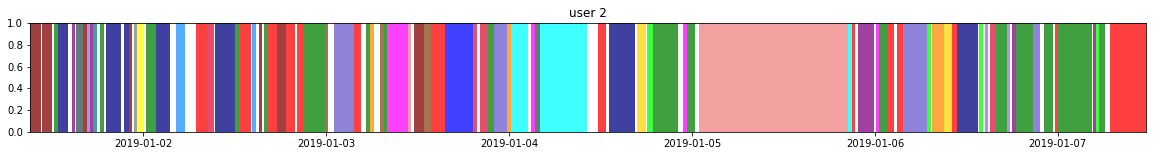

In [15]:
ax = cluster_tdf[drange].plot_diary(agent_id)

In [16]:
cluster_tdf[drange & (cluster_tdf['uid'] == agent_id)].head()

,uid,datetime,lat,lng,leaving_datetime,cluster
188,2,2019-01-01 09:09:43.889550,45.847685,11.015608,2019-01-01 10:30:49.800904,3
189,2,2019-01-01 10:44:18.215694,45.847685,11.015608,2019-01-01 11:58:43.779012,3
190,2,2019-01-01 12:18:01.051262,45.839141,10.989545,2019-01-01 12:46:47.162499,1
191,2,2019-01-01 12:46:47.162499,45.857355,10.977313,2019-01-01 14:08:40.608939,2
192,2,2019-01-01 14:35:36.265667,45.829695,11.014958,2019-01-01 15:02:45.292624,6


In [17]:
from skmob.measures.individual import jump_lengths, radius_of_gyration, waiting_times

In [18]:
jls_df = jump_lengths(tdf)
jls_df.head()

100%|██████████| 100/100 [00:00<00:00, 217.49it/s]


,uid,jump_lengths
0,1,"[0.0, 6.707301525670519, 0.0, 0.0, 6.707301525..."
1,2,"[0.0, 0.0, 0.0, 1.412529571737859, 2.235914893..."
2,3,"[0.0, 2.001031957368494, 2.001031957368494, 4...."
3,4,"[0.0, 7.7979660246395195, 0.0, 21.220651063360..."
4,5,"[9.206318494600902, 9.206318494600902, 26.5757..."


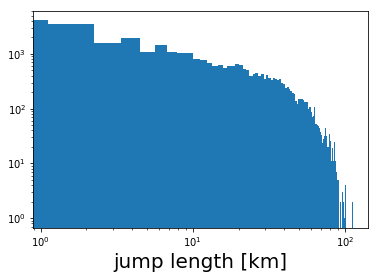

In [19]:
jls = []
for x in jls_df.jump_lengths:
    jls.extend(x)

plt.hist(jls, bins=100)
plt.xlabel('jump length [km]', fontsize=20)
plt.loglog()
plt.show()

In [20]:
wts_df = waiting_times(tdf)
wts_df.head()

100%|██████████| 100/100 [00:00<00:00, 604.43it/s]


,uid,waiting_times
0,1,"[939.0, 609.0, 1783.0, 660.0, 1539.0, 1569.0, ..."
1,2,"[856.0, 983.0, 869.0, 1474.0, 4865.0, 808.0, 1..."
2,3,"[967.0, 4040.0, 1659.0, 2819.0, 1006.0, 2113.0..."
3,4,"[2744.0, 721.0, 1052.0, 31302.0, 13621.0, 1417..."
4,5,"[11838.0, 1542.0, 932.0, 3035.0, 768.0, 6885.0..."


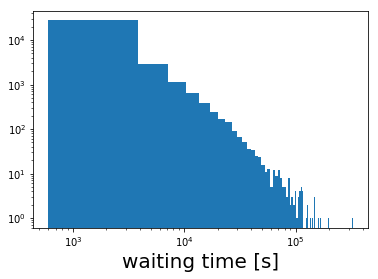

In [21]:
wts = []
for x in wts_df.waiting_times:
    wts.extend(x)

plt.hist(wts, bins=100)
plt.xlabel('waiting time [s]', fontsize=20)
plt.loglog()
plt.show()

100%|██████████| 100/100 [00:00<00:00, 271.86it/s]


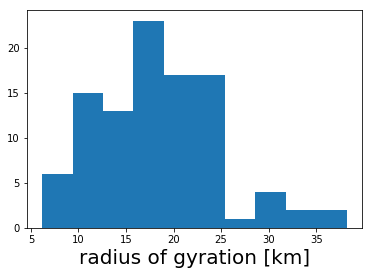

In [22]:
rg_df = radius_of_gyration(tdf)
plt.hist(rg_df.radius_of_gyration.values, bins=10)
plt.xlabel('radius of gyration [km]', fontsize=20)
plt.show()